In [66]:
import numpy as np
import skimage.transform
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest' 
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


## Dictionary to map file keys from STScI to Krist

In [67]:
telap_key_map = {'hex1':'hex1', 'hex2':'hex2', 'hex3':'hex3', 'hex4':'hex4',
                 'key24':'keystone24', 'pie08':'piewedge8', 'pie12':'piewedge12'}
secobs_key_map = {'Cross':'cross', 'X':'x'}

## set directory of telescope aperture and list contents

In [68]:
#telap_dir = os.path.abspath('../Apertures/JPL/offset_masks')
telap_dir = os.path.abspath('/astro/opticslab1/SCDA/Apertures/JPL/offset_masks')
print telap_dir
print("Contents:")
os.listdir(telap_dir)

/astro/opticslab1/SCDA/Apertures/JPL/offset_masks
Contents:


['t_spiders_2000pix_2.5cm_offset.fits',
 'y_spiders_60deg_2000pix_2.5cm_offset.fits',
 't_spiders_1000pix_10.0cm_offset.fits',
 'cross_spiders_1000pix_2.5cm_offset.fits',
 'y_spiders_60deg_1000pix_2.5cm_offset.fits',
 'hex2_1000pix_offset.fits',
 'y_spiders_60deg_1000pix_10.0cm_offset.fits',
 'offset_y_spiders_60deg_1000pix_10.0cm_offset.fits',
 'x_spiders_1000pix_10.0cm_offset.fits',
 'y_spiders_60deg_2000pix_10.0cm_offset.fits',
 'y_spiders_90deg_2000pix_10.0cm_offset.fits',
 'x_spiders_2000pix_10.0cm_offset.fits',
 'keystone24_2000pix_offset.fits',
 'offset_y_spiders_60deg_2000pix_10.0cm_offset.fits',
 'offset_y_spiders_60deg_1000pix_2.5cm_offset.fits',
 'piewedge8_2000pix_offset.fits',
 'cross_spiders_2000pix_10.0cm_offset.fits',
 'piewedge12_1000pix_offset.fits',
 'x_spiders_1000pix_2.5cm_offset.fits',
 'hex2_2000pix_offset.fits',
 'y_spiders_90deg_1000pix_10.0cm_offset.fits',
 't_spiders_1000pix_2.5cm_offset.fits',
 'y_spiders_90deg_1000pix_2.5cm_offset.fits',
 'cross_spiders_100

## Set basic parameters

In [69]:
telap_key = "hex4"
secobs_key = "X"
centobs_key = True
D = 2000
N = 250 # quadrant width after binning

## Load an aperture and a secondary obstruction, plot the product

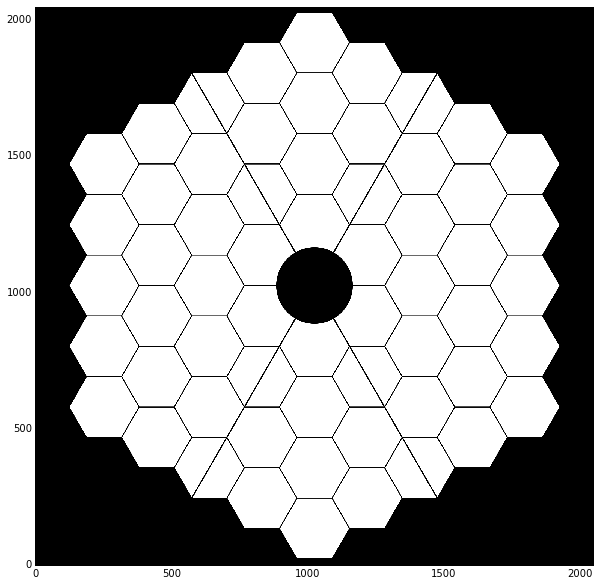

In [70]:
if centobs_key is True:
    telap_fname = os.path.join(telap_dir, "{0:s}_{1:04d}pix_offset.fits".format(telap_key_map[telap_key], D))
    secobs_fname = os.path.join(telap_dir, "{0:s}_spiders_{1:04d}pix_2.5cm_offset.fits".format(
                                           secobs_key_map[secobs_key], D))
else:
    telap_fname = os.path.join(telap_dir, "{0:s}_{1:04d}pix_offset_no_central_obsc.fits".format(telap_key_map[telap_key], D))
    secobs_fname = os.path.join(telap_dir, "{0:s}_spiders_{1:04d}pix_2.5cm_offset.fits".format(
                                           secobs_key_map[secobs_key], D))
    
telap_hdulist = fits.open(telap_fname, "readonly")
telap_orig = telap_hdulist[0].data
telap_hdulist.close()
secobs_hdulist = fits.open(secobs_fname, "readonly")
secobs = secobs_hdulist[0].data
secobs_hdulist.close()
telap_obs = telap_orig*secobs
plt.figure(figsize=(10,10))
#plt.imshow(telap_orig)
plt.imshow(telap_obs)

### Test the symmetry

In [71]:
L = telap_obs.shape[0]
telap_left = telap_obs[:,:L/2] # left half
telap_right = telap_obs[:,L/2:] # right half
telap_top = telap_obs[L/2:,:] # left half
telap_bot = telap_obs[:L/2,:] # right half
leftright_diff = telap_left - telap_right[:,::-1]
topbot_diff = telap_top - telap_bot[::-1,:]
max_abs_leftright_diff = np.max(np.abs(leftright_diff))
max_abs_topbot_diff = np.max(np.abs(topbot_diff))
print('Max absolute left-right difference = {:g}'.format(max_abs_leftright_diff))
print('Max absolute top-bottom difference = {:g}'.format(max_abs_topbot_diff))

Max absolute left-right difference = 9.96289e-06
Max absolute top-bottom difference = 2.3898e-05


In [72]:
#plt.figure(figsize=(10,6))
#plt.subplot(121)
#plt.imshow(leftright_diff)
#plt.colorbar()
#plt.subplot(122)
#plt.imshow(topbot_diff.T)
#plt.colorbar()

## Bin to abritrary integer size, crop to quadrant

In [73]:
N_orig = 1000 # not 1024
scalefac = float(N)/N_orig
#telap_bin = scipy.ndimage.zoom(telap_obs, scalefac, order=1)
telap_bin = skimage.transform.rescale(telap_obs, scalefac, order=1)
L_bin = telap_bin.shape[0]

In [74]:
telap_bin.shape

(512, 512)

In [75]:
telap_binquad = telap_bin[L_bin/2:L_bin/2+N, L_bin/2:L_bin/2+N]
telap_binquad.shape
# Check max value of outer row and outer column
print np.max(telap_binquad[-1,:])
print np.max(telap_binquad[:,-1])

1.0
0.0


(-0.5, 249.5, -0.5, 249.5)

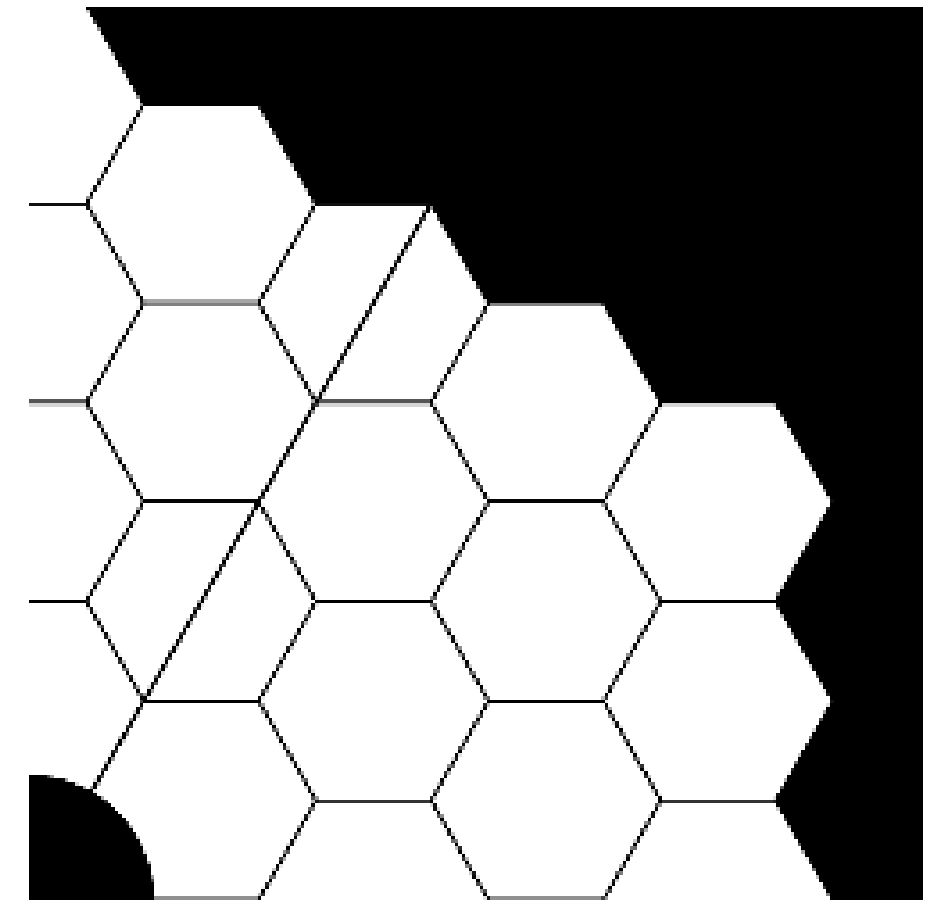

In [76]:
plt.figure(figsize=(16,16))
plt.imshow(telap_binquad)
#plt.imshow(np.floor(telap_binquad))
#plt.imshow(telap_binquad.astype(int))
plt.axis('off')

### Form new FITS filename and write

In [77]:
binned_telap_dir = os.path.abspath("../TelAP")
if not os.path.exists(binned_telap_dir):
    os.mkdir(binned_telap_dir)
    print("created {:s} for binned aperture arrays".format(binned_telap_dir))
else:
    print("Destination {:s} already exists".format(binned_telap_dir))

Destination /Users/ntz/SCDA/TelAP already exists


In [78]:
if centobs_key is True:
    telap_binquad_dat_fname_tail = "TelAp_quart_{0:s}_{1:s}025c1_N{2:04d}.dat".format(telap_key, secobs_key, N)
    telap_binquad_dat_fname = os.path.join(binned_telap_dir, telap_binquad_dat_fname_tail)
else:
    telap_binquad_dat_fname_tail = "TelAp_quart_{0:s}_{1:s}025c0_N{2:04d}.dat".format(telap_key, secobs_key, N)
    telap_binquad_dat_fname = os.path.join(binned_telap_dir, telap_binquad_dat_fname_tail)

#telap_binquad_fits_fname_tail = "TelAp_quart_{0:s}_{1:s}025sm1_N{2:04d}.fits".format(telap_key, secobs_key, N)
#telap_binquad_fits_fname = os.path.join(binned_telap_dir, telap_binquad_fits_fname_tail)

In [79]:
#telap_binquad_hdu = fits.PrimaryHDU(telap_binquad)
#telap_binquad_hdu.writeto(telap_binquad_fits_fname, clobber=True)

In [80]:
np.savetxt(telap_binquad_dat_fname, telap_binquad, fmt='%.6f', delimiter=" ")
print("Wrote binned, cropped telescope aperture array to {0:s}".format(telap_binquad_dat_fname))

Wrote binned, cropped telescope aperture array to /Users/ntz/SCDA/TelAP/TelAp_quart_hex4_X025c1_N0250.dat


In [81]:
os.listdir(binned_telap_dir)

['TelAp_quart_hex4_X025c0_N0250.dat',
 'TelAp_quart_hex4_X025c1_N0250.dat',
 'TelAp_quart_hex4_X025sm1_N0250.dat']

In [82]:
#telap_load = np.loadtxt(telap_binquad_dat_fname)

In [83]:
#plt.figure(figsize=(16,16))
#plt.imshow(np.floor(telap_load))